<p style="font-size:78px">Final Project IRWA (2024-2025)</p>

# Part 3: Ranking

## 0) Loading and setup

In [4]:
# Standard library imports
import os
import sys

# Third-party imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gensim.models.word2vec import Word2Vec
from sklearn.manifold import TSNE
from transformers import BertTokenizer, BertModel
import seaborn as sns

# Local application imports
current_dir = os.path.dirname(os.path.abspath(__file__)) if '__file__' in locals() else os.getcwd()
project_root = os.path.join(current_dir, '..')
if project_root not in sys.path:
    sys.path.append(project_root)
import irwa.loading as ild 
import irwa.preprocessing as ipp
import irwa.indexing as ind
import irwa.ranking as irk
import irwa.evaluation as eva
import irwa.utils as ut


# The following lines allow for autoreload of modules. They allow changes in modules without the need to reload the kernel.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# Loading
file_path = '../data/farmers-protest-tweets.json'
tweets = ild.load_tweets_from_json(file_path)
print(f"Loaded {len(tweets)} tweets")

# Preprocessing
tweet_document_ids_map_df = "../data/tweet_document_ids_map.csv"
docid_to_tweetid, token_tweets = ipp.create_tokenized_dictionary(tweets, tweet_document_ids_map_df)
print(f"Loaded {len(token_tweets)} documents with their corresponding tokenized tweet content")

Loaded 117407 tweets
Loaded 48429 documents with their corresponding tokenized tweet content


In [6]:
query1 = "What is the indian protest?"          
query2 = "Where to support the farmers?"        
query3 = "Who are the Delhi farmers?"          
query4 = "Is the government corrupt?"       
query5 = "What do farmers fight for?"
queries = [query1, query2, query3, query4, query5]               

## 1) TF-IDF + cosine similarity, custom score, and BM25 

### a) TF-IDF + cosine simmilarity

To increase the computational efficiency of the ranking process, we avoid creating full TF-IDF vectors for the document and query. Instead, we compute only the values for the dimensions corresponding to query terms. This approach does not impact the scalar product between the query and document vectors; however, it does limit our ability to normalize the result. To address this, we account for document length directly when calculating term frequency. In contrast to the previous lab, we do not require our documents to have all the words present in the query.

In [7]:
# Create inverted index
inverted_index, tf, idf = ind.create_inverted_index_tf_idf(token_tweets)

In [8]:
# Ranking results with TF-IDF and cosine simmilarity
ranked_documents_tf_idf = irk.rank_documents_tf_idf(ipp.build_terms(query1), token_tweets, inverted_index, tf, idf, document_filtering=None)
irk.display_scores(ranked_documents_tf_idf, docid_to_tweetid, tweets, 20)

ut.save_scores_to_csv(ranked_documents_tf_idf, filename="../data/tf_idf_ranking.csv")


Top 20 Results:
------------------------------------------------------------
RESULT 1
Document doc_34729: 5.031061026856039
Content: Indian farmers' protests: Why they matter to British Indians
#FarmersProtest  https://t.co/kyCWnDVyEm
------------------------------------------------------------
RESULT 2
Document doc_19653: 4.865420574825832
Content: @PunYaab Farmers are Indian ... Each n every person in protest is Indian first ... So think before tweets against protesters 

#farmersprotest
------------------------------------------------------------
RESULT 3
Document doc_33904: 4.592709354323596
Content: Indian farmers' protests: Why they matter to British Indians

#FarmersStandingFirm #FarmersProtest #StandWithFarmers 

https://t.co/ywgPhLCvm9
------------------------------------------------------------
RESULT 4
Document doc_9676: 4.485696129303427
Content: This is why Indian Farmers are protesting #FarmersProtest https://t.co/9mzFBGQaXL
-----------------------------------------------

### b) Our score

In [9]:
ranked_documents_our_score_15 = irk.rank_documents_our_score(tweets, docid_to_tweetid, ranked_documents_tf_idf, alpha=0.15, k0 = 0.5, k1=0.5,k2=1,k3=0.5)
irk.display_scores(ranked_documents_our_score_15, docid_to_tweetid, tweets, 20)

ut.save_scores_to_csv(ranked_documents_our_score_15, filename="../data/our_score15_ranking.csv")

Top 20 Results:
------------------------------------------------------------
RESULT 1
Document doc_23286: 1.0
Content: Arresting #ClimateChange activist #DishaRavi is a huge mistake by Indian police ! It has now taken the #FarmersProtest to another level &amp; audience ! 

The human rights of all activists &amp; protesters must be respected ! 

#FreeDishaRavi !
------------------------------------------------------------
RESULT 2
Document doc_13630: 0.7149785414775238
Content: Keep Supporting "Peaceful Farmers Protest"

#DPstoplntimidatingFarmers
#FarmersProtest #KisanAndolan #SupportFarmers #AustraliaSupportingFarmers #DigitalKisan #DigitalKisanMorcha https://t.co/D5darStzw9
------------------------------------------------------------
RESULT 3
Document doc_44034: 0.6907963039454892
Content: Guys !!

Please keep using the following hashtags for any farmers protest related posts. 

#FarmersProtest #StandWithFarmers
------------------------------------------------------------
RESULT 4
Do

In [10]:
ranked_documents_our_score_70 = irk.rank_documents_our_score(tweets, docid_to_tweetid, ranked_documents_tf_idf, alpha=0.7, k0 = 0.5, k1=0.5,k2=1,k3=0.5)
irk.display_scores(ranked_documents_our_score_70, docid_to_tweetid, tweets, 20)

ut.save_scores_to_csv(ranked_documents_our_score_70, filename="../data/our_score70_ranking.csv")

Top 20 Results:
------------------------------------------------------------
RESULT 1
Document doc_23286: 1.0
Content: Arresting #ClimateChange activist #DishaRavi is a huge mistake by Indian police ! It has now taken the #FarmersProtest to another level &amp; audience ! 

The human rights of all activists &amp; protesters must be respected ! 

#FreeDishaRavi !
------------------------------------------------------------
RESULT 2
Document doc_13630: 0.7147723951615937
Content: Keep Supporting "Peaceful Farmers Protest"

#DPstoplntimidatingFarmers
#FarmersProtest #KisanAndolan #SupportFarmers #AustraliaSupportingFarmers #DigitalKisan #DigitalKisanMorcha https://t.co/D5darStzw9
------------------------------------------------------------
RESULT 3
Document doc_44034: 0.6906381520057274
Content: Guys !!

Please keep using the following hashtags for any farmers protest related posts. 

#FarmersProtest #StandWithFarmers
------------------------------------------------------------
RESULT 4
Do

### c) BM25

#### i) k1=1.2 and b = 0.7

In [11]:
# Ranking results with TF-IDF
ranked_documents_bm25_b7 = irk.rank_documents_bm25(ipp.build_terms(query1), token_tweets, inverted_index, tf, idf)
irk.display_scores(ranked_documents_bm25_b7, docid_to_tweetid, tweets, 20)

ut.save_scores_to_csv(ranked_documents_bm25_b7, filename="../data/bm25_ranking_b7.csv")

Top 20 Results:
------------------------------------------------------------
RESULT 1
Document doc_19653: 7.578828703860777
Content: @PunYaab Farmers are Indian ... Each n every person in protest is Indian first ... So think before tweets against protesters 

#farmersprotest
------------------------------------------------------------
RESULT 2
Document doc_34729: 7.556960017742792
Content: Indian farmers' protests: Why they matter to British Indians
#FarmersProtest  https://t.co/kyCWnDVyEm
------------------------------------------------------------
RESULT 3
Document doc_9676: 7.295058025055637
Content: This is why Indian Farmers are protesting #FarmersProtest https://t.co/9mzFBGQaXL
------------------------------------------------------------
RESULT 4
Document doc_33904: 7.178802751748759
Content: Indian farmers' protests: Why they matter to British Indians

#FarmersStandingFirm #FarmersProtest #StandWithFarmers 

https://t.co/ywgPhLCvm9
-----------------------------------------------

#### ii) k=1.2 and b = 0.15

In [12]:
# Ranking results with TF-IDF
ranked_documents_bm25_b15 = irk.rank_documents_bm25(ipp.build_terms(query1), token_tweets, inverted_index, tf, idf, b= 0.15)
irk.display_scores(ranked_documents_bm25_b15, docid_to_tweetid, tweets, 20)

ut.save_scores_to_csv(ranked_documents_bm25_b15, filename="../data/bm25_ranking_b15.csv")

Top 20 Results:
------------------------------------------------------------
RESULT 1
Document doc_13095: 7.474697562162942
Content: INDIAN FARMERS are protesting in DELHI for last 3 months. 220+ farmers had died so far in #FarmersProtest .Protests are held all over the world to show solidarity with Indian Farmers.A protest will be held in Australia this Sunday.
#DPstopIntimidatingFarmers
@UNHumanRights
@bbc https://t.co/Ct5hqEEXRE
------------------------------------------------------------
RESULT 2
Document doc_19653: 7.351107914844778
Content: @PunYaab Farmers are Indian ... Each n every person in protest is Indian first ... So think before tweets against protesters 

#farmersprotest
------------------------------------------------------------
RESULT 3
Document doc_30537: 7.135246745964769
Content: @KahlonRav @MrBigShot01 @jjhorgan Thank you @jjhorgan for being a constant voice for Indians protesting right now. @JustinTrudeau must continue urging Indian Govnt to uphold democracy dur

### Comparison

In [13]:
# Read the CSV files
tfidf_df = pd.read_csv("../data/tf_idf_ranking.csv").head(20)
our_score_15_df = pd.read_csv("../data/our_score15_ranking.csv").head(20)
our_score_70_df = pd.read_csv("../data/our_score70_ranking.csv").head(20)
bm25_b7_df = pd.read_csv("../data/bm25_ranking_b7.csv").head(20)
bm25_b15_df = pd.read_csv("../data/bm25_ranking_b15.csv").head(20)

In [14]:
def plot_rank_comparison(dfs, score_cols, token_tweets):
    """
    Plots accumulated position points for documents across selected scoring methods.

    Parameters:
    - dfs: Dictionary where keys are method names and values are dataframes with 'Document ID' and 'score' columns.
    - score_cols: List of keys from dfs to specify which methods to compare.
    """
    # Rename columns and assign ranking points
    for name in dfs:
        dfs[name].rename(columns={'Document ID': 'document_id', 'score': f'points_{name}'}, inplace=True)
        dfs[name][f'points_{name}'] = range(20, 0, -1)  # Rank position points: 1 = 20, 2 = 19, ..., 20 = 1

    # Merge dataframes based on selected methods
    merged_df = dfs[score_cols[0]][['document_id', f'points_{score_cols[0]}']]
    for col in score_cols[1:]:
        merged_df = pd.merge(merged_df, dfs[col][['document_id', f'points_{col}']], on='document_id', how='outer')

    # Fill NaN values with 0 for documents not present in all rankings
    merged_df.fillna(0, inplace=True)

    # Calculate total points across selected methods
    merged_df['total_points'] = merged_df[[f'points_{col}' for col in score_cols]].sum(axis=1)

    # Sort documents by total points
    merged_df.sort_values(by='total_points', ascending=False, inplace=True)

    # Prepare data for stacked bar plot
    documents = merged_df['document_id']
    colors = ['skyblue', 'lightgreen', 'salmon', 'plum', 'orange']  # Predefined colors for up to 5 methods
    color_map = {col: colors[i % len(colors)] for i, col in enumerate(score_cols)}

    # Create a new list of formatted document labels with lengths
    formatted_documents = [f"{doc} ({len(token_tweets[doc])})" for doc in documents]

    # Plot
    fig, ax = plt.subplots(figsize=(9, 7))
    
    # Accumulate points for each method in a stacked manner
    left_values = [0] * len(documents)
    for col in score_cols:
        bars = ax.barh(formatted_documents, merged_df[f'points_{col}'], left=left_values, color=color_map[col], label=col)
        
        # Add point value annotations inside each bar
        for bar, value in zip(bars, merged_df[f'points_{col}']):
            if value > 0:  # Only annotate non-zero points
                value = 21 - value
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    bar.get_y() + bar.get_height() / 2,
                    f'{int(value)}',
                    ha='center', va='center', color='black', fontsize=8, weight='bold'
                )
                
        left_values = left_values + merged_df[f'points_{col}']

    # Add legend and labels
    ax.set_xlabel('Total Points (Based on Ranking Position)')
    ax.set_title('Accumulated Position Points by Document in Selected Top 20 Rankings')
    ax.legend(loc='lower right')
    
    # Show plot
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest rank at the top
    plt.tight_layout()
    plt.show()

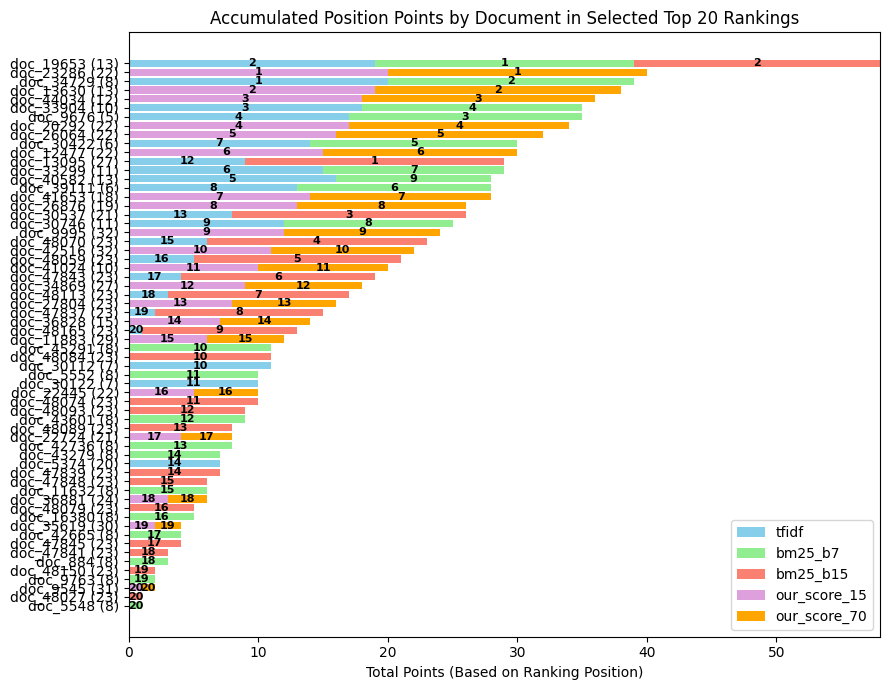

In [15]:
# Dataframes in a dictionary with custom names
dfs = {
    'tfidf': tfidf_df,
    'our_score_15': our_score_15_df,
    'our_score_70': our_score_70_df,
    'bm25_b7': bm25_b7_df,
    'bm25_b15': bm25_b15_df

}

# Plot only tfidf and bm25
plot_rank_comparison(dfs, ['tfidf','bm25_b7','bm25_b15','our_score_15', 'our_score_70'], token_tweets)

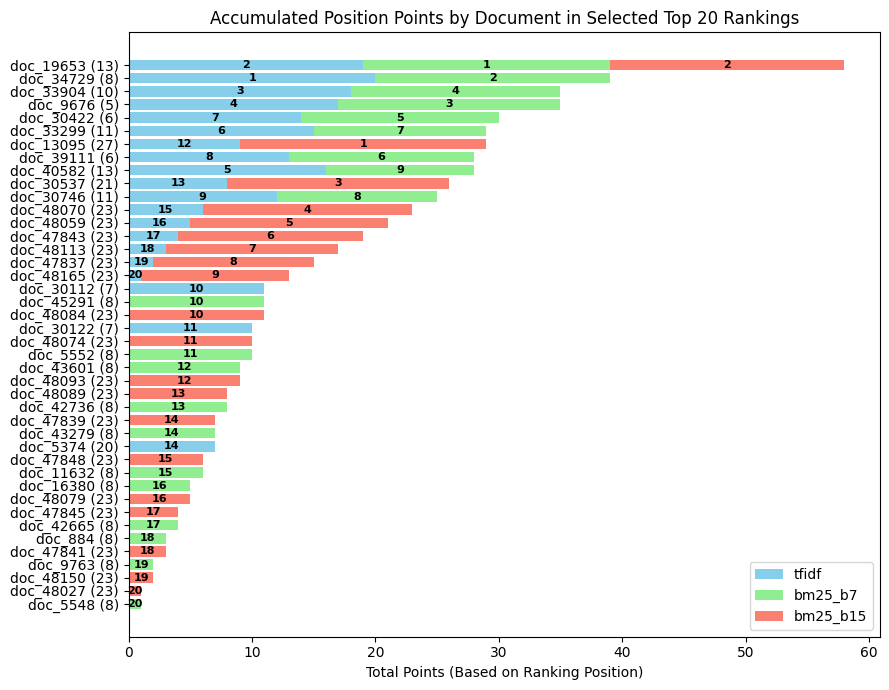

In [16]:
# Plot only tfidf and bm25
plot_rank_comparison(dfs, ['tfidf','bm25_b7', 'bm25_b15'], token_tweets)

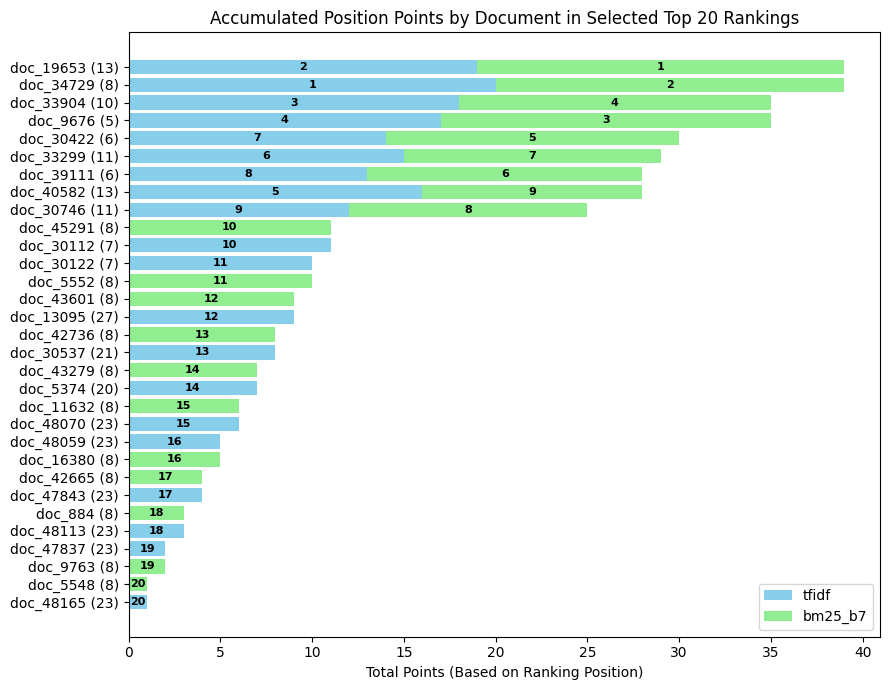

In [17]:
plot_rank_comparison(dfs, ['tfidf', 'bm25_b7'], token_tweets)

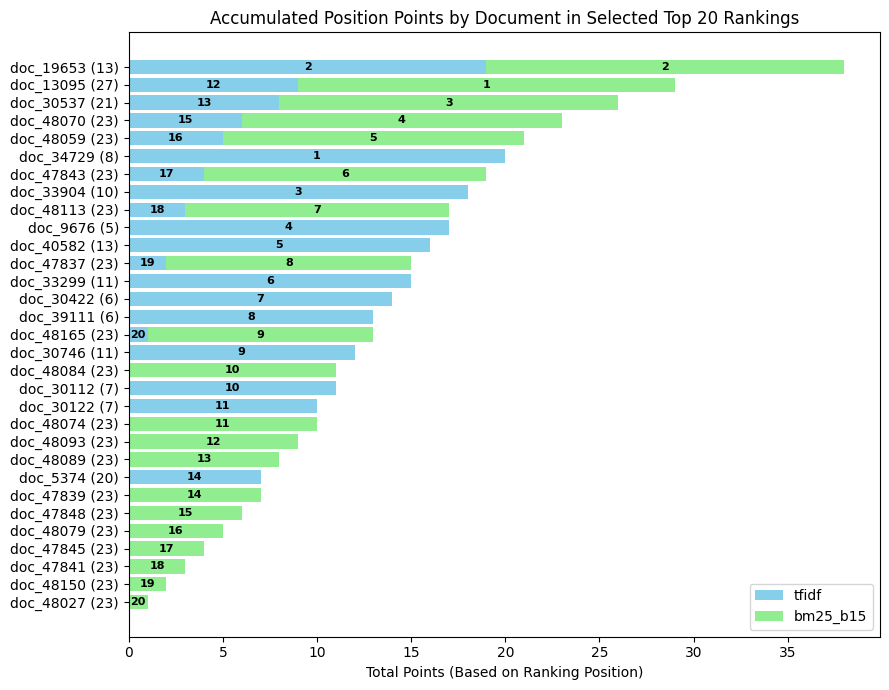

In [18]:
plot_rank_comparison(dfs, ['tfidf', 'bm25_b15'], token_tweets)

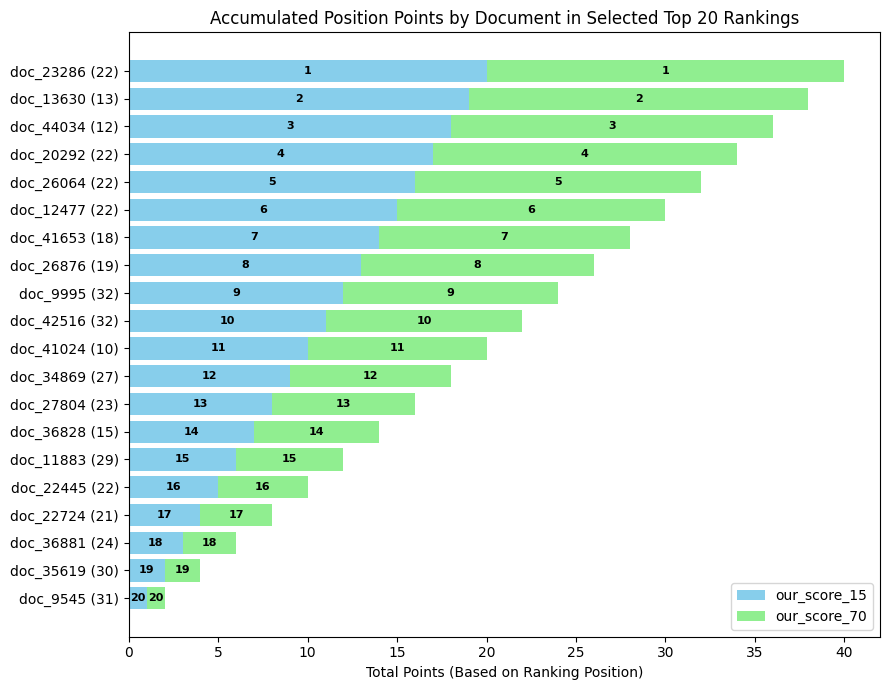

In [19]:
# Plot only tfidf and bm25
plot_rank_comparison(dfs, ['our_score_15', 'our_score_70'], token_tweets)

## 2) Word2vec with cosine similarity

In [20]:
# Train the Word2Vec model based on the tokens present in the corpus of documents
model = Word2Vec(token_tweets.values(), workers=4, vector_size=100, min_count=50, window=10, sample=1e-3)
# Compute a vector representation for each of the documents
tweet2vec_dict = irk.tweet2vec(token_tweets, model)

### a) Query 1

In [21]:
scores = irk.tweet2vec_cossim(tweet2vec_dict, model, ipp.build_terms(queries[0]))
irk.display_scores(scores, docid_to_tweetid, tweets, n=20)

Top 20 Results:
------------------------------------------------------------
RESULT 1
Document doc_23958: 0.8919370770454407
Content: Indian journalist ⁦@RanaAyyub⁩ has spoken to ⁦@MSNBC⁩ host Chris Hayes regarding the #FarmersProtest in India titled: “Modi’s “Arrogance of Power” and the Indian Farmers’ Protests with Rana Ayyub  https://t.co/1FILm2CMF7
------------------------------------------------------------
RESULT 2
Document doc_34729: 0.8898035883903503
Content: Indian farmers' protests: Why they matter to British Indians
#FarmersProtest  https://t.co/kyCWnDVyEm
------------------------------------------------------------
RESULT 3
Document doc_30746: 0.8868465423583984
Content: @steve_hanke This is the largest crowd I have ever seen in a protest, except for the Indian Farmers protest.
#FarmersProtest
------------------------------------------------------------
RESULT 4
Document doc_9676: 0.8738487958908081
Content: This is why Indian Farmers are protesting #FarmersProtest https:/

### b) Query 2

In [22]:
scores = irk.tweet2vec_cossim(tweet2vec_dict, model, ipp.build_terms(queries[1]))
irk.display_scores(scores, docid_to_tweetid, tweets, n=20)

Top 20 Results:
------------------------------------------------------------
RESULT 1
Document doc_2815: 0.9999999403953552
Content: Support Farmers 🙏🙏🙏🙏🙏🙏#FarmersProtest
------------------------------------------------------------
RESULT 2
Document doc_15412: 0.9999999403953552
Content: Support Farmers 🙏🙏🙏🙏🙏#FarmersProtest
------------------------------------------------------------
RESULT 3
Document doc_28796: 0.9999999403953552
Content: Support Farmers 🙏🙏🙏🙏🙏#FarmersProtest
------------------------------------------------------------
RESULT 4
Document doc_45741: 0.9999999403953552
Content: Support Farmers 🙏🙏🙏🙏🙏🙏#FarmersProtest
------------------------------------------------------------
RESULT 5
Document doc_38864: 0.9203510880470276
Content: support farmers support #FarmersProtest 
#शहीद_जवान_शहीद_किसा
------------------------------------------------------------
RESULT 6
Document doc_43187: 0.9200344085693359
Content: Support farmers support farmers support Twitter #FarmersProtest  

### c) Query 3

In [23]:
scores = irk.tweet2vec_cossim(tweet2vec_dict, model, ipp.build_terms(queries[2]))
irk.display_scores(scores, docid_to_tweetid, tweets, n=20)

Top 20 Results:
------------------------------------------------------------
RESULT 1
Document doc_28594: 0.8791465759277344
Content: #IamAgainstModiGovtPeriod Sadly he could not see the lakhs of farmers protesting outside Delhi when he was flying out of Delhi . #IamAgainstModiGovt #FarmersProtest https://t.co/sPv2j1CpZ5
------------------------------------------------------------
RESULT 2
Document doc_29107: 0.8791465759277344
Content: Sadly he could not see the lakhs of farmers protesting outside Delhi when he was flying out of Delhi .

#IamAgainstModiGovt 
#FarmersProtest https://t.co/JHrtbfYjOg
------------------------------------------------------------
RESULT 3
Document doc_30534: 0.8791465759277344
Content: Sadly he could not see the lakhs of farmers protesting outside Delhi when he was flying out of Delhi .

#IamAgainstModiGovt 
#FarmersProtest https://t.co/UDuCBv5aMg
------------------------------------------------------------
RESULT 4
Document doc_29928: 0.8683249950408936
Co

### d) Query 4

In [24]:
scores = irk.tweet2vec_cossim(tweet2vec_dict, model, ipp.build_terms(queries[3]))
irk.display_scores(scores, docid_to_tweetid, tweets, n=20)

Top 20 Results:
------------------------------------------------------------
RESULT 1
Document doc_13309: 0.8728195428848267
Content: Shame on government
No family..no feelings. 
Just move your tail around corporates...

Shame on BJP GOVERNMENT

#DPstopIntimidatingFarmers
#FarmersProtest https://t.co/DTVuiOFCnm
------------------------------------------------------------
RESULT 2
Document doc_4328: 0.8642876744270325
Content: Nothing different between British government and Modi Government. I think British government was more sensitive than this Modi Government because they repealed the laws but this government is too much ignorant.
#FarmersProtest
#DPstopIntimidatingFarmers
#Pagdi_Sambhal_Jatta
------------------------------------------------------------
RESULT 3
Document doc_14701: 0.8599290251731873
Content: Corruption Corruption thats what this Government will be Remembered for #DPstopIntimidatingFarmers
#FarmersProtest https://t.co/7QsxGwbWmr
--------------------------------------

### e) Query 5

In [25]:
scores = irk.tweet2vec_cossim(tweet2vec_dict, model, ipp.build_terms(queries[4]))
irk.display_scores(scores, docid_to_tweetid, tweets, n=20)

Top 20 Results:
------------------------------------------------------------
RESULT 1
Document doc_27381: 0.9532130360603333
Content: You might not be a farmer but you arent a robot either, you are a consumer.🥗 🍛 

 Farmer's fight is your fight too

#FarmersProtest

 19:28:11
------------------------------------------------------------
RESULT 2
Document doc_35772: 0.9532130360603333
Content: You might not be a farmer but you arent a robot either, you are a consumer.🥗 🍛 

 Farmer's fight is your fight too

#FarmersProtest

 21:30:11
------------------------------------------------------------
RESULT 3
Document doc_683: 0.9510731101036072
Content: You might not be a farmer but you arent a robot either, you are a consumer.🥗 🍛 

 Farmer's fight is your fight too

#FarmersProtest #Pagdi_Sambhal_Jatta

 04:28:09
------------------------------------------------------------
RESULT 4
Document doc_3694: 0.9510731101036072
Content: You might not be a farmer but you arent a robot either, you are a

### f) Embedding Analysis

#### i) Word embeddings: Word2Vec

The key concept of Word2Vec is to locate words, which share common contexts in the training corpus, in close proximity in the vector space in comparison with others.

In [26]:
k = 30
_, most_common_words_all = ut.word_count(token_tweets, top_words=k, count_type='all')
words = [word[0] for word in most_common_words_all]
print(f"Top {k} most common words: {words}")

Top 30 most common words: ['#farmersprotest', 'farmer', 'india', 'support', 'protest', 'amp', 'right', 'peopl', 'indian', 'govern', 'modi', 'law', '#releasedetainedfarm', 'govt', 'stand', 'bjp', '#farmersmakeindia', '#indiabeingsilenc', 'thank', 'pleas', '#disharavi', 'farm', '#mahapanchayatrevolut', 'world', 'need', 'like', 'one', 'us', 'arrest', '#repealonlywayahead']


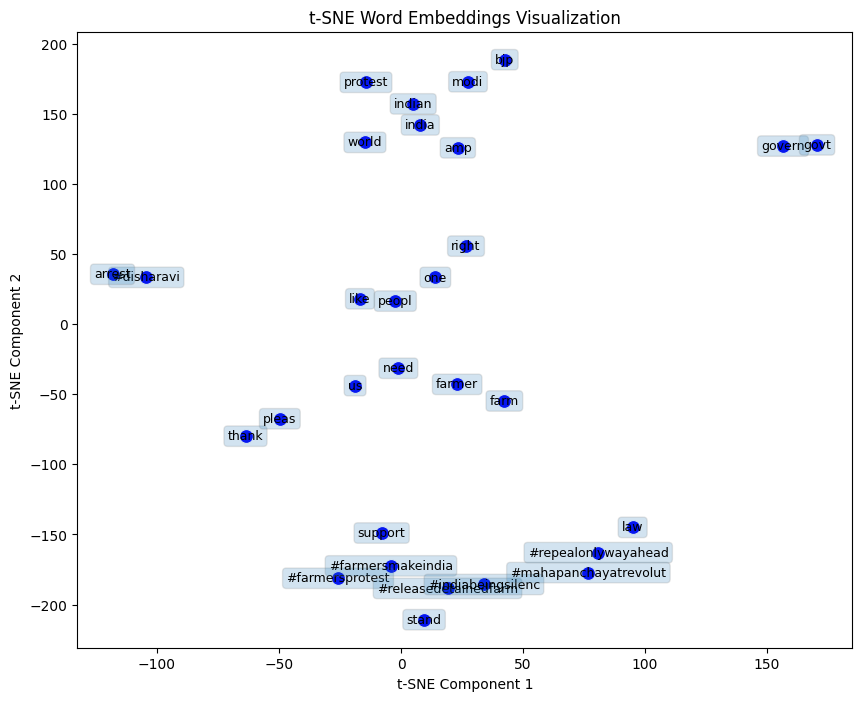

In [27]:

# Assuming `model` and `words` are already defined
vectorized_words = np.array([model.wv[word] for word in words])

# t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42, perplexity=2)
reduced_vectorized_words = tsne.fit_transform(vectorized_words)

# Create a DataFrame for the reduced vectors
tsne_df = pd.DataFrame(reduced_vectorized_words, columns=['t-SNE Component 1', 't-SNE Component 2'])
tsne_df['word'] = words

# Plotting
plt.figure(figsize=(10, 8))
sns.scatterplot(data=tsne_df, x='t-SNE Component 1', y='t-SNE Component 2', s=100, color='blue')

# Add labels to each point
for i, row in tsne_df.iterrows():
    plt.text(row['t-SNE Component 1'], row['t-SNE Component 2'], row['word'], 
             fontsize=9, ha='center', va='center', bbox=dict(boxstyle="round,pad=0.3", edgecolor='gray', alpha=0.2))

plt.title("t-SNE Word Embeddings Visualization")
plt.show()


The plot illustrates how the embedding captures the semantic relationships between individual words. Interchangeable words, such as govt and govern, exhibit high similarity. It is also noteworthy that the words Disha Ravi (#disharavi) and arrest demonstrate high similarity. To provide context for this observation, Disha Ravi was a climate activist who was arrested on February 13, 2021, for alleged involvement with an online toolkit related to Greta Thunberg and the 2020–2021 Indian farmers' protests.

#### ii) Contextual embeddings: BERT

In [28]:
n = 50
top_tweets = [tweet for _,_,tweet in ut.top_retweeted_tweets(tweets, tweet_document_ids_map_df, n=n)]
top_tweets_ids = [tweetid for tweetid,_,_ in ut.top_retweeted_tweets(tweets, tweet_document_ids_map_df, n=n)]
print(f"Top {n} most retweeted tweets: {top_tweets}")

Top 50 most retweeted tweets: ["There's a #FarmersProtest happening in Germany.\n\nBut the German Govt didn’t block their path with barbed wires, dig highways or label them Anti-National. And neither did the Govt declare it an ‘internal matter’ where others can’t comment. I guess that’s how democracies work. https://t.co/pZtigTgWT8", 'disha ravi, a 21-year-old climate activist, has been arrested by delhi police for sharing a toolkit @GretaThunberg  posted in support of the #farmersprotest. \n\ndisha’s arrest is alarming and the world needs to pay attention. #freedisharavi\n\nhttps://t.co/IYGsLpNjwZ', 'Disha Ravi broke down in court room and told judge that she had merely edited two lines in the toolkit and was supporting farmers. What is wrong in that? This is how this nation treats anyone who spreads awareness. #FarmersProtest', 'Farmers are so sweet. Y’all have to see this @AmandaCerny @rihanna 🖤🥺 #FarmersProtest #ModiWhereAreMissingFarmers #ReleaseDetainedFarmers https://t.co/STVWhW

/tmp/ipykernel_20986/483823832.py:28: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(
/tmp/ipykernel_20986/483823832.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Categories")


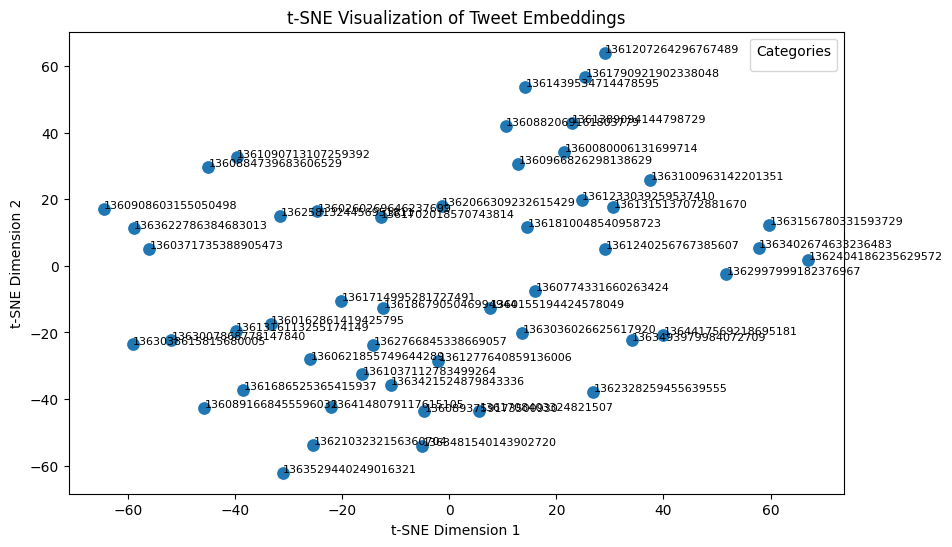

Tweet ID: 1364148079117615105
Tweet: There's a #FarmersProtest happening in Germany.

But the German Govt didn’t block their path with barbed wires, dig highways or label them Anti-National. And neither did the Govt declare it an ‘internal matter’ where others can’t comment. I guess that’s how democracies work. https://t.co/pZtigTgWT8


Tweet ID: 1360882069161803779
Tweet: disha ravi, a 21-year-old climate activist, has been arrested by delhi police for sharing a toolkit @GretaThunberg  posted in support of the #farmersprotest. 

disha’s arrest is alarming and the world needs to pay attention. #freedisharavi

https://t.co/IYGsLpNjwZ


Tweet ID: 1360908603155050498
Tweet: Disha Ravi broke down in court room and told judge that she had merely edited two lines in the toolkit and was supporting farmers. What is wrong in that? This is how this nation treats anyone who spreads awareness. #FarmersProtest


Tweet ID: 1360162861419425795
Tweet: Farmers are so sweet. Y’all have to see this @Aman

In [29]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')


# Tokenize the tweets with padding and truncation
tokenized_tweets = tokenizer(
    top_tweets,
    padding=True,
    truncation=True,
    return_tensors="pt"
)


outputs = bert_model(**tokenized_tweets)

# Extract the [CLS] token embeddings
cls_embeddings = outputs.last_hidden_state[:, 0, :]  # Shape: [number_of_tweets, hidden_size]

cls_embeddings_numpy = cls_embeddings.detach().numpy()


# Perform t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
tweet_embeddings_2d = tsne.fit_transform(cls_embeddings_numpy)

# Visualize the t-SNE output
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=tweet_embeddings_2d[:, 0],
    y=tweet_embeddings_2d[:, 1],
    palette="tab10",
    s=100
)

# Annotate the points with tweet text (optional)
for i, tweet in enumerate(top_tweets):
    plt.text(
        tweet_embeddings_2d[i, 0] + 0.1,
        tweet_embeddings_2d[i, 1] + 0.1,
        top_tweets_ids[i],
        fontsize=8
    )

plt.title("t-SNE Visualization of Tweet Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Categories")
plt.show()

for tweet, tweetid in zip(top_tweets, top_tweets_ids):
    print(f"Tweet ID: {tweetid}\nTweet: {tweet}\n\n")


From the plot above, we can see that transformers capture the semantics of the sentences. Here are two close tweets:


Tweet ID: 1361790921902338048
Tweet: india is targeting young women to silence dissent &amp; muzzle free speech. 21yo climate activist #DishaRavi was arrested for tweeting a benign google doc about the #farmersprotest. bjp ministers have called for her “eradication” &amp; their online army "jokes" about her custodial rape

Tweet ID: 1361207264296767489
Tweet: Disha Ravi is 21; a student &amp; climate activist
Nodeep Kaur is 24; a labourer &amp;  Union activist
Both women were targeted, arrested &amp; imprisoned for peacefully supporting the #FarmersProtest
This suppression is driven by authoritarianism &amp; free market capitalism
Don’t Be Silent
